Make sure that `nff` is in your path:

In [1]:
import sys

sys.path.insert(0, "..")
sys.path.insert(0, "../..")

# Running CP3D scripts

This folder contains scripts for doing ChemProp3D tasks. These include making a dataset out of pickle files with species information, and training a CP3D model using this dataset. Below are some details about how to use the different folders.

## Table of Contents

- [Making a dataset](#making-a-dataset)
    * [Splitting the data](#splitting-the-data)
    * [Generating the dataset from splits and pickles](#generating-the-dataset-from-splits-and-pickles)
    * [Adding custom features](#adding-custom-features)
    * [Reducing the number of conformers](#reducing-the-number-of-conformers)
- [Training](#training)
    * [Running the script](#running-the-script)
    * [The config file](#the-config-file)
        * [SchNet model parameters](#schnet-model-parameters)
        * [ChemProp3D model parameters](#chemprop3d-model-parameters)
        * [Training parameters](#training-parameters)
- [Hyperparameter optimization](#hyperparameter-optimization)
- [Transfer learning](#transfer-learning)
    * [Getting fingerprints, predictions, and learned weights](#gett-fingerprints,-predictions,-and-learned-weights)
    * [Exporting fingerprints to ChemProp](#exporting-fingerprints-to-chemprop)
    * [Training ChemProp models with the fingerprints](#training-chemprop-models-with-the-fingerprints)
    * [Saving the predictions](#saving-the-predictions)



## Making a dataset

The scripts for making a dataset assume that you have a set of pickle files in a folder, one for each species, each of which contains all the 3D information about the conformers. It also assumes that you have one summary `JSON` file, which tells you all the properties of each species (except for its 3D information), and the path to the pickle file. This follows the organization of the GEOM dataset. More information about this organization can be found [here](https://github.com/learningmatter-mit/geom/blob/master/tutorials/02_loading_rdkit_mols.ipynb). 

The script `scripts/cp3d/make_dset/make_dset.sh` first generates training, validation and test splits from your summary file. It interfaces with ChemProp to do so, so that you can use functionality like ChemProp's scaffold split. It then uses the splits you've generated, together with the pickle files, to create train, validation, and test datasets complete with all the 3D information. The following two sections discuss the two functions that `make_dset.sh` calls. You can run `make_dset.sh` or you can run the individual scripts themselves.

### Splitting the data
The script `scripts/cp3d/make_dset/splits/split.sh` uses your summary file to get information about the data, generates a CSV of the data for ChemProp to read, and uses ChemProp to split the data. Details for the script are in `scripts/cp3d/make_dset/splits/split.sh/split_config.json`, which you should modify for your project. The keys are:

- `summary_path` (str): The path to the `JSON` file that contains a summary of the superset (the species from which you will sample to make your dataset). It has all the information about the species, excluding conformer/structural information. It also has the path to the corresponding pickle file, which has the structural information.
- `csv_folder` (str): The folder in which you want to save your CSV files with the train, test, and split species.
- `cp_folder` (str): The path to the ChemProp folder on your computer
- `props` (list[str]): a list of the properites that you want your model to predict. We currently support one-class classification or multi-class regression.
- `split_sizes` (list[float]): train, validation, and split proportions for the dataset
- `split_type` (str): The method for splitting the data. This option gets used in ChemProp, and so it can be any of the methods supported by ChemProp (currently `random` and `scaffold_balanced`).
- `max_specs` (int): Maximum number of species to include in your dataset. No maximum is imposed if `max_specs` is None
- `max_atoms` (int): Maximum number of atoms for a species that you will allow in your dataset. If you don't want a limit, set this value to None. 
- `dataset_type` (str): Type of model you're training. Currently `classification` and `regression` are supported.

Running the script will generate CSV files, save them in `csv_folder`, and print a summary for you.


### Generating the dataset from splits and pickles
To make a CP3D dataset from a set of pickle files, we run the script `scripts/cp3d/make_dset/dset_from_pickles.sh`. This script can be used when you have a pickle file for each species. The pickle file should contain the following keys:

- `smiles`: The SMILES string of the species
- `conformers`: a list of dictionaries for each conformer
    - Each dictionary should contain at least the keys `boltzmannweight`, for the statistical weight of the conformer, and  `rd_mol`, an RDKit `mol` object for the conformer. If you don't have a statistical weight, or you only have one conformer, then simply set `boltzmannweight` to 1 /  <number_of_conformers>.
    - If it doesn't contain `rd_mol` then it should contain `xyz` for the coordinates of the conformer. In this case the script will call `xyz2mol` to generate an RDKit `mol` object.
    - If you are using the RDKit pickles from the GEOM dataset, then a more in-depth discussion of the structure of the pickle files can be found [here](https://github.com/learningmatter-mit/geom/blob/master/tutorials/02_loading_rdkit_mols.ipynb).
    
Details for the script are found in the file `dset_config.json`. This is where you should change the values for your project. The keys in the file are:
- `max_confs` (int): Maximum number of conformers for a species that you will allow in your dataset. If you don't want a limit, set this value to None.
- `summary_path` (str): The path to the `JSON` file that contains a summary of the superset (the species from which you will sample to make your dataset). It has all the information about the species, excluding conformer/structural information. It also has the path to the corresponding pickle file, which has the structural information.
- `dataset_folder` (str): The path to the folder you want to save your dataset in.
- `pickle_folder` (str): The path to the folder that contains the pickle files.
- `num_threads` (int): How many files you want to divide your total dataset into. Conformer datasets can get quite large, so you may not want a single huge dataset that can't be loaded into memory. Instead you may want `num_threads` datasets. For example, if you perform parallel training with `N` GPUs, then you'll want to set `num_threads` to `N`. During train time, each parallel GPU thread will only read in one of these `N` datasets. For `m` GPUs per node, the node will only have to hold `m / N` of the total dataset in memory.
- `csv_folder` (str): The folder in which you've saved your CSV files with the train, test, and split species.
- `parallel_feat_threads` (int): Number of parallel threads to use when featurizing the dataset

### Adding custom features 
The script automatically generates atom and bond features, but you can add other features to the dataset too. 

- Morgan fingerprint. The Morgan fingerprint is a classic 2D bit vector fingerprint. Given a dataset called `dset` and a desired fingerprint length `vec_length`, call `dset.add_morgan(vec_length)`
- E3FP. The E3FP fingerprint is a 3D version of the Morgan fingerprint. To generate E3FP fingerprints call `dset.add_e3fp(vec_length)`. (Note, however, that creating a conda environment with the latest versions of both RDKit and E3FP leads to clashes, and so the `nff` environment does not automatically contain E3FP functionality. If you want to generate an E3FP fingerprint, you will have to create a new environment with E3FP and an older version of RDKit).
- RDKit descriptors. RDKit has a variety of 3D descriptors, such as `autocorrelation_3d`, `rdf`, `morse`, `whim` and `getaway`. To generate features with any of these methods, call `dset.featurize_rdkit(method)`.

To load, modify, and save a dataset, run:

```
from nff.data import Dataset
dset = Dataset.from_file(<path>)
<dset.add_e3fp(100), dset.featurize_rdkit('rdf'), ...>
dset.save(<path>)
```

If you are interested in adding other types of features then you can write your own class methods to generate them!




### Reducing the number of conformers

If you've already made a dataset and you want to reduce the number of conformers, you can do that by running the script `scripts/cp3d/make_dset/trim_confs.sh`. The only arguments you need are:
- `from_model_path` (str): The old path to the model and dataset. The script assumes your datasets are in the folders `from_model_path/0`, `from_model_path/1`, ..., etc., as they would be if generated using the `dset_from_pickles.sh`.
- `to_model_path` (str) The path to the new dataset with fewer conformers
- `num_confs` (int): Number of conformers that you want in the new dataset

Of course you can always just run `dset_from_pickles.sh` again, but using fewer conformers. But running `trim_confs.sh` might save some time if your pickle files don't contain `rdmols`. In this case you'd have to generate `rdmols` from `xyz`'s all over again, which would not be worth it! 



## Training

Now that we have a dataset, we're ready to train a model! The model can be trained by running `scripts/cp3d/train/train_parallel.sh`.

### Running the script

- This is a Slurm batch script. If you have access to a cluster that is managed by the Slurm scheduler, you can run `sbatch train_parallel.sh`, and the training will take place on the cluster. You may have to modify some of the slurm keywords (those that come after `#SBATCH`) depending on your cluster partitions, available number and make of GPUs, etc. You can request >= 1 node and >= 1 GPU per node, and the script will automatically parallelize over GPUs and nodes.
- If you don't have access to a cluster but have access to >= 1 GPU, you can run `bash train_parallel.sh`. You will have to set `use_slurm=False` and `num_gpus = <number_of_gpus_you_have>` in the config file (see below).
- If you don't have access to a cluster don't have access to a GPU, you can run `bash train_single.sh` and set `device` to `cpu` in the config file (see below).
- If you have access to > 1 node and > 1 GPU, but the nodes are not managed by Slurm, then you can run multi-GPU training but not multi-node training. However, `train_parallel.py` and `train_parallel.sh` are not too difficult to decipher, and you should be able to modify them to parallelize over nodes using your scheduler.
    
### The config file


The script loads parameters from `scripts/cp3d/train/train_config.json`. The two main keys in this file are `model_params` and `train_params`.

- `model_params` (dict): A dictionary with all parameters required to create a model. Its sub-keys are:
    - `model_type` (str): The kind of model you want to make. The currently supported options are `WeightedConformers`, which builds a SchNet model with pooled conformer fingerprints, and `SchNetFeatures`, which builds a ChemProp3D model with pooled conformers. If your dataset only contains one conformer per species, then each model will still work!
    - An assortment of other keys, which depend on the model type. Below we go through each key for the two different model types.

    
    
#### SchNet model parameters

An example of a `WeightedConformers` config file is `schnet_config.json`. The keys required for `WeightedConformers` are as follows:

- `mol_basis` (int): Dimension of the molecular fingerprint
- `dropout_rate` (float) : Dropout rate applied to the convolutional layers
- `activation` (str): Name of the activation function to use in the convolutional layers.
- `n_atom_basis` (int): Dimension of the atomic feature vector created by embedding the atomic number.
- `n_convolutions` (int): How many convolutions to apply to generate the fingerprint
- `cutoff` (float): cutoff distance used to define neighboring atoms. Note that whatever cutoff you used to generate your neighbor list in the dataset should be the cutoff you use here. 
- `n_gaussians` (int): Number of Gaussians, evenly spaced between 0 and `cutoff`, used for transforming the interatomic distances.
- `n_filters` (int): Dimension into which the edge features will be transformed. Note that the edge features are embedded in a basis of `n_gauss` Gaussian functions, and are then transformed into a vector of dimension `n_filters`.        
- `mol_fp_layers` (list[dict]): a list of dictionaries. Each dictionary will be turned into a neural network layer. The way this is done is by creating a layer given by the name in `name` and with the parameters specified in `param`. Once the atomic feature vectors are summed after the convolutions, these layers will be applied sequentially to create a final molecular fingerprint. The final dimension after these layers should be equal to `mol_basis`.

Note that if `n_atom_basis` is not equal to `mol_basis`, you must supply at least one linear layer to convert it to the right dimension. If they are equal, you can simply set `mol_fp_layers = []`, and no transformation will be applied to them.

- `boltzmann_dict` (dict): A dictionary that tells you how to use the conformer fingerprints and Boltzmann weights to pool the conformers together. The key `type` tells you the kind of pooling:
    - If set to `multiply`, the fingerprints will be multiplied by the corresponding Boltzmann weights and summed. No other keys need to be specified.
    - If set to `attention`, then an attention mechanism $\alpha_{ij}$ will be applied between each pair of conformers $ij$. In this case one must also specify the following parameters:
        - `dropout_rate` (float): Dropout rate for the layers that create the attention mask
        - `final_act` (str): Activation function applied after the weighted sum of conformer fingerprints
        - `num_heads` (int): Number of attention heads
        - `head_pool` (str): If you are using multiple attention heads, the way in which you combine the fingerprints that are pooled from the different heads. If set to `sum`, then these fingerprints are summed and the readout layer should take as input a vector of dimension `mol_basis`. If set to `concatenate`, then they are concatenated  and the readout layer should take as input a vector of dimension `num_heads` x `mol_basis`.
        - `mol_basis` (int): Dimension of the molecular fingerprint. Should have the same value as in the main dictionary.
        - `boltz_basis` (int): Dimension of the vector into which the Boltzmann statistical weight will be converted.
        - `equal_weights` (bool): Whether to forego the learned attention mechanism and just use equal weights for each conformer. This is useful as an ablation study.
    - If set to `linear_attention`, then an attention mechanism $\alpha_i$ will be applied between conformers $i$.
        - In this case the same keys are required as for `attention`.
- `readoutdict` (dict): A dictionary that tells you how to convert the final pooled fingerprint into a prediction. Each key corresponds to the name of a different quantity to predict. Each value is a list of layer dictionaries telling you which layers to apply sequentially. 

In the example given in `schnet_config.json`, a vector of size 900 (3x `mol_basis` because of three attention heads with concatenation) is converted to size 450 through a linear layer. Then a dropout layer and the ReLU activation are applied. Then another linear layer converts it to size 1, and a final dropout layer is applied. Note that this does not have a sigmoid layer because the model is trained with a BCELogits loss, which is equal to cross-entropy loss + sigmoid, but is more stable. At inference you must remember to apply the sigmoid layer! 

- `batch_embeddings` (bool): Whether to use fingerprints already present in the dataset instead of learning the fingerprints. In this case the dataset properties must contain fingerprints under the key `fingerprints`.
- `trainable_gauss` (bool): Whether the width and spacings of the Gaussian functions are learnable parameters.
- `extra_features` (list]): a list of names of any extra features to concatenate with the learned features. Each dictionary only needs the key `name`, which tells you the name of the feature in the dataset. 

For example, if you have Morgan fingerprints in your dataset and you want to concatenate these with the learned fingerprints, you can set `extra_features=["morgan"]`.

- `base_keys` (list[str]): names of the values that your model is predicting
- `grad_keys` (list[str]): any values for which you also want the gradient with respect to nuclear coordinates. For example, if you are predicting energies then you may also want the gradients, as the negative gradients are the nuclear forces.


    
#### ChemProp3D model parameters


An example of a `ChemProp3D` config file is `train_config.json` (this is the default used in `train_parallel.sh` and `train_single.sh`). Most of the keys required for `WeightedConformers` are the same as for weighted SchNet conformers. The remaining keys are as follows:
    
- `n_atom_basis` (int): This is also present for SchNet conformers. But there it could be any number, and here it must be equal to the dimension of the atomic feature vector generated from the molecular graph. In ChemProp3D that number is 133.
- `n_bond_features` (int): Same as `n_atom_basis`, but for the bond features. It must be equal to the dimension of the bond feature vector generated from the molecular graph. In ChemProp3D that number is 26.
- `n_bond_hidden` (int): The dimension of the hidden vector that the bond feature vector is transformed into.
- `input_layers` (list[dict]): A list of layer dictionaries that tell you how to convert cat([atom_vec, bond_vec]) into a hidden vector. Since `n_atom_basis=133` and `n_bond_features=26`, the input dimension must be `133+26 = 159`. Since `n_bond_hidden=300`, the output dimension must be 300.
- `output_layers` (list[dict]): A list of layer dictionaries that tell you how to convert cat([atom_vec, edge_vec]) into a set of atomic feature vectors after the convolutions. Here `atom_vec` is the initial atomic feature vector and `edge_vec` is the updated edge feature vector after convolutions. `edge_vec` has length `n_bond_hidden + n_filters`, because it is a concatenation of the graph edge features and the 3D geometry edge features. Therefore, `output_layers` must have an input dimension of `n_atom_basis + n_bond_hidden + n_filters = 133 + 300 + 64 = 497`. Its output can have any size. However, if the output size is not equal to `mol_basis`, then `mol_fp_layers` must account for this to make a molecular feature vector of the right size.
- `same_filters` (bool): Whether to use the same learned SchNet filters for every convolution. This was false in the original SchNet paper.

        
#### Training parameters

- `train_params` (dict): A dictionary with information about the training process. The required keys are the same for all model types. They are:

    - `use_slurm` (bool): Use slurm when running parallel training. If set to true, the script will use Slurm variables to find the number of GPUs and nodes. 
    - `num_gpus` (int): Number of GPUs to use in parallel training. Must be set if not using slurm for parallel training. Otherwise doesn't need to be set.

    If you are using slurm for parallel training, make sure to manually change `SLURM_GPUS_PER_NODE` in the `train_parallel.sh` script, so that it's equal to the number of GPUs you request per note in `#SBATCH`. 

    Also, make sure to change `NFFDIR` in the script to the location of your NeuralForceField folder.

    - `seed` (int): random seed used in training.
    - `batch_size` (int): Number of molecules to include in a batch. Note that this is the batch size when accounting for *all nodes and GPUs*. So, if you have 8 nodes and 2 GPUs each, that makes 16 GPUs total. So a batch size of 16 means that each GPU will use 1 batch at a time. That is, the per-gpu batch size is 1.
    - `mini_batches` (int): How many batches to go through before taking an optimizer step. Say you only put one molecule in a batch at a time, but set `mini_batches` to 4. Then you only need memory for one molecule at a time, but your optimizer step will include gradients accumulated from 4 molecules.
    - `model_kwargs` (dict): Any keyword arguments to use when calling the model. For all conformer models, thee only keyword to worry about is `sub_batch_size`. This is the number of sub-batches you want to divide each batch into. For more than about 10 conformers per species, most GPUs won't be able to calculate fingerprints in parallel for all conformers of a species. 7 is usually a good choice for a typical GPU. 

    Note that if you set `sub_batch_size` to anything but `None`, then your per-gpu batch size should always be 1. That's why the config file has `batch_size=16` (since the slurm script requests 2x8 = 16 GPUs, this makes a per-gpu batch size of 1).

    - `sampler` (dict): Optional argument for the kind of sampler you want for your data. If specified, the only alternative to random is `ImbalancedDataSampler`, which makes sure you see equal amounts of each label in a classification problem. Simply set `name` in the dictionary to `ImbalancedDataSampler` and set `target_name` to the property name that you want to sample in a balanced way.

    - `loss_coef` (dict): A dictionary with weights for different losses. If you are training a model that predicts more than one quantity, then you have to decide how to weight the losses of each parameter. The dictionary is of the form `{name_0: weight_0, name_1: weight_1, ...}` etc, for the name and loss weight of each quantity. 
    - `loss` (str): The type of loss. Can be `cross_entropy` (for classification, if the output has a sigmoid layer), `logits_cross_entropy` (same, but without a sigmoid layer), or `mse` (mean square error; for regression tasks).
    - `mol_loss_norm` (bool): normalize the loss of a batch by the number of molecules in it, rather than the number of atoms in it.
    - `metrics` (list[str]): Metrics to monitor throughout training. Can be `RocAuc`, `PrAuc`, or `MAE` (mean absolute error).
    - `metric_as_loss` (str): By default the trainer saves the best model as the one with the lowest validation loss. If instead you want one with, say, the highest validation ROC for predicting the quantity `sars_cov_one_cl_protease_active`, then set `metric_as_loss` to `PrAuc_sars_cov_one_cl_protease_active`.
    - `metric_objective` (str): If you have set `metric_as_loss` to `PrAuc_sars_cov_one_cl_protease_active`, then setting `metric_object=maximize` means that you want to maximize this quantity. Setting `metric_object=minimize` means that you want to minimize it (this would be the case for MAE, for example).

    - `lr` (float): initial learning rate
    - `lr_patience` (int): How many epochs you can go without the validation loss improving before dropping the learning rate
    - `lr_decay` (float < 1): factor by which to multiply the learning rate after the loss hasn't improved for `lr_patience` epochs.
    - `lr_min` (float): minimum learning rate. The training will stop once the learning rate drops below this value.
    - `max_epochs` (int): Maximum number of training epochs.

    - `logger` (str): Only option is `csv`. If set to `csv` then the model performance will be logged every `log_every_n_epochs` epochs.
    - `log_every_n_epochs` (int): How often to log progress
    - `checkpoints_to_keep` (int): How many past models to keep before deleting them. Say you trained a model to keep label the best model as the one with the lowest loss. But then you want to go back and get the model that had the highest PRC-AUC. Then you can look at the training log, find the epoch with the highest validation PRC-AUC, and load the model from the `checkpoints` folder. If you do not set `checkpoints_to_keep >= max_epochs`, then you run the risk of not being able to find this model and load it.
    - `torch_par` (bool): use built-in PyTorch functionality to do parallel training. The alternative is to save gradients to disk and have parallel processes read these gradients. While PyTorch's functionality is likely faster, we have found the simple disk save to be far less error-prone.
    - `del_grad_interval` (int): If using disk parallelization, you should delete the saved gradients after you are sure they have been loaded by the parallel processes. `del_grad_interval` tells you that you can delete all saved files from >= `del_grad_interval` batches earlier.

    - `weight_path` (str): path to the folder that contains all the models
    - `model_name` (str): name of the model you're training. The model will be saved and logged in `weight_path/model_name`. 
    
    Conformer datasets can get quiet large, so it is often useful to save chunks of the dataset separately. If you are using disk parallelization over `N=n_gpus x n_nodes` different GPUs, and you want to save separate chunks, then the dataset should broken up into `N` different folders and saved in `weight_path/model_name`. For example, if you are training with 2 GPUs and 3 nodes, then you should have 6 folders in `weight_path/model_name`, called 0, 1, 2, 3, 4, and 5. Each folder should contain `train.pth.tar`, `val.pth.tar`, and `test.pth.tar` (i.e. `weight_path/model_name/0/train.pth.tar`, `weight_path/model_name/0/val.pth.tar`, `weight_path/model_name/0/test.pth.tar`, `weight_path/model_name/1/train.pth.tar`, etc.) . If you generated a dataset using `scripts/cp3d/make_dset/dset_from_pickles.sh`, then you should set `num_threads` to `N`, and this will be done automatically for you. 
    
    This is not required, however; you can save the entire dataset centrally (`weight_path/model_name/train.pth.tar`, `weight_path/model_name/val.pth.tar`, `weight_path/model_name/test.pth.tar`). In this case the script will use PyTorch distributed sampling to sample parts of the dataset on each different GPU. However, the distributed sampler hasn't been combined with the option of using a custom sampler such as `ImbalancedDataSampler`. Therefore, you cannot use `ImbalancedDataSampler` and also save the dataset in one location.
    
    If you are using PyTorch parallelization then you must save the entire dataset centrally.


## Hyperparameter optimization

A basic random search algorithm is available for optimizing hyperparameters. The script is `scripts/cp3d/hyperopt/random_search.sh`. The config file is `scripts/cp3d/hyperopt/search_config.json`. Its keys are:
- `job_path` (str): The path to the training config file. This file will be modified with different hyperparameters throughout the search.
- `model_path` (str): The folder that your model lives in
- `param_names` (list[str]): parameters that you want to optimize. The simple script currently allows optimizing SchNet, ChemProp and readout dropout rates, as well as the number of attention heads. It shouldn't be too difficult to add extra options!
- `data_types` (list[str]): The data type of each parameter. For example, if you have a dropout parameter (float) and number of heads (int), then this should be `["float", "int"]`.
- `min_vals` (list): minimum value each hyperparameter
- `max_vals` (list): maximum value of each hyperparameter
- `num_samples` (int): number of hyperparameter combinations to try
- `metric` (str): metric with which to evaluate model performance. Can be `prc-auc`, `auc`, `loss`, or `mae`.
- `prop_name` (str): Name of the property whose performance you want to optimize. If you're using `metric=loss` then this won't matter.
- `score_file` (str): Name of the `JSON` file in which you store the model performance for each hyperparameter set.


## Transfer learning

There may be cases in which there are two similar regression/classification tasks, but one task has significantly more data than the other. This is the case, for example, with SARS-CoV-2 binding prediction. There is an available dataset with over 300,000 molecules for SARS-CoV binding, but only a few thousand for SARS-CoV-2 binding. In this case it can help to train a model on the larger dataset, then use the model to generate fixed fingerprints for the smaller dataset. These fixed fingerprints can then be used to train a model on the smaller set.

As detailed in our paper, we have found that using this transfer learning technique with CP3D yields significantly better results for SARS-CoV-2 binding than any 2D methods. 

Scripts are available for transfer learning `scripts/cp3d/transfer`. The main script is `transfer.sh`, which runs the following four scripts in order. Note that you can run any of the scripts on their own if you want (for example, if you've already made fingerprints, you can skip the first script below). Also note that making fingerprints and saving predictions is useful even if you're not doing transfer learning.

### Getting fingerprints, predictions, and learned weights
The script `get_fps/make_fps.sh` uses the model to generate pooled fingerprints for species in other datasets. It also reports the model prediction for the property of interest, the real value of the property, the individual conformer fingerprints (before nonlinearities), the learned weights that multiply the conformer fingerprints (after nonlinearities), the energy of each conformer, and the conformer Boltzmann weights. These are quite useful for comparing fingerprints between and among species, and for seeing how the model learned to weight each fingerprint. 

- Details for the script are found in the file `get_fps/fp_config.json `. This is where you should change the values for your project. The keys in the file are:
    - `model_folder` (str): Folder in which the model is saved
    - `dset_folder` (str): Folder in which the dataset is saved. The dataset contains the data for which you want to add fingerprints.
    - `feat_save_folder` (str): Folder in which you want to save pickle files with the fingerprints.
    - `prop` (str): Name of the property that the model predicts, and that you want to save. If you just want to make fingerprints and don't want to the model predictions you can leave this unspecified.
    - `device` (str): Device you want to use when calling the model. Can be "cpu" or any integer from 0 to the number of GPUs you have available, if you want to use a GPU.
    - `batch_size` (int): Batch size when evaluating the model
    - `sub_batch_size` (int): Number of sub-batches you want to divide each batch into. For more than about 10 conformers per species, most GPUs won't be able to calculate fingerprints in parallel for all conformers of a species. 7 is usually a good choice for a typical GPU.
    - `test_only` (bool): Only create fingerprints and evaluate the model on the test set. This is useful if you just want the model predictions on the test set and aren't interested in transfer learning.
    - `add_sigmoid` (bool): Add a sigmoid layer at the end of the model. This should be done if you are doing classification and training with the BCELogits loss.
    - `metrics` (list[str]): The script will loop through each metric and use the model with the best validation score according to that metric. It will create fingerprints and predictions for all of the different models. Any metrics recorded during training can be used here, such as `auc`, `prc-auc`, `loss`, and `mae`.

        
### Exporting fingerprints to ChemProp

The script `export_to_cp/save_feats.sh` exports the pickle files generated by `make_fps.sh` to a form readable by ChemProp.
- Details for the script are in `export_to_cp/feat_config.json`. The keys are:
    - `feat_folder` (str): Folder in which you saved the pickle files from the model. Should be the same as `feat_save_folder` above.
    - `cp_save_folder` (str): Folder in which you want to save the exported ChemProp features.
    - `smiles_folder` (str): Folder in which the train, validation and test SMILES strings are saved. The files should be named `train_smiles.csv`, `val_smiles.csv`, and `test_smiles.csv`.
    - `metrics` (list[str]): Subset of the `metrics` above for which you want to export features to ChemProp.
        
### Training ChemProp models with the fingerprints

The script `run_cp/run_all_tls.sh` runs ChemProp using the features generated above. It can loop through all CP3D models from which you generated features (e.g. model with the best `auc`, model with the best `prc`, etc.), and through combinations of training with features + MPNN and training with features alone. 
- Details for the script are in `run_cp/all_tls_config.json`. The keys are:
    - `base_config_path` (str): Path to the config file for the ChemProp. All of these parameters will be used for the ChemProp runs, except if you specify `metrics`, `features_path` or `features_only`, as these will change as you loop through the combinations of `metrics`, `feat_options`, and `mpnn_options` below. 
    - `cp_folder` (str): Path to the ChemProp folder on your computer.
    - `feature_folder` (str): Folder in which the features you generated above for ChemProp are saved. 
    - `model_folder_cp` (str): Folder in which you will make sub-folders for all your ChemProp models.
    - `metrics` (list[str]): Subset of the metrics above. For every metric there exists a corresponding best CP3D model and associated CP3D features. A new ChemProp model will be trained for every different set of these features. The associated ChemProp model will also be scored on that metric. 
    - `feat_options` (list[bool]): Whether to use the CP3D features in the ChemProp model. If you specify [True, False], then separate models will be trained, one in which they are used and one in which they aren't. This might be useful if you want to compare performance with and without 3D features.
    - `mpnn_options` (list[bool]):  Whether to use an MPNN in conjunction with the CP3D features in the ChemProp model. If you specify [True, False], then separate models will be trained, one in which an MPNN is used and one in which it isn't. 

### Saving the predictions
Now that we've trained our models we want to get and save their predictions. That way we can do further analysis afterwards. For example, if we've trained a model to maximize the PRC-AUC but we want to also see what the model's ROC-AUC is, we'll have to get its predictions and do the analysis ourselves.

The script that generates predictions is `run_cp/predict.sh`. Details for the script are in `run_cp/predict_config.json`. The keys are:
- `cp_folder` (str): Path to the ChemProp folder on your computer.
- `model_folder_cp` (str): Folder in which you made sub-folders for all your ChemProp models.
- `device` (str): Device you want to use when calling the model. Can be "cpu" or any integer from 0 to the number of GPUs you have available, if you want to use a GPU.
- `test_path` (str): path to the file with the test SMILES and their properties. If you split the data using the scripts above, then this should be equal to `<csv_folder>/test_full.csv`.





# Making a dataset

To make a dataset we'll need two things. First, we need a folder consisting of pickle files, one for each species. Second we'll need a `JSON` file that summarizes the information about each of the species. 

This tutorial will use the `GEOM` dataset as an example. To follow along, download the file `rdkit_folder.tar.gz` from [this page](https://www.dropbox.com/sh/1aptf9fi8kyrzg6/AABQ4F7dpl4tQ_pGCf2izd7Ca?dl=0). Untar the file by running
```
tar -xzvf rdkit_folder.tar.gz
```
in the command line. This should generate a folder called rdkit_folder. We'll define `pickle_folder` as the full path to this RDKit folder, and `summary_path` as the full path to the summary file:



In [66]:
import os

# change to wherever you have downloaded the zip file
directory = "/home/saxelrod/rgb_nfs/GEOM_DATA_ROUND_2"

rd_folder = os.path.join(directory, "rdkit_folder")
summary_path = os.path.join(directory, "summary_drugs.json")

You can find more information about the structure of the GEOM dataset and loading the files [here](https://github.com/learningmatter-mit/geom).



TO-DO:
- Fix the script because right now it won't work for testing after training is done
- Fix the sub-batch issue when batch_size > 1

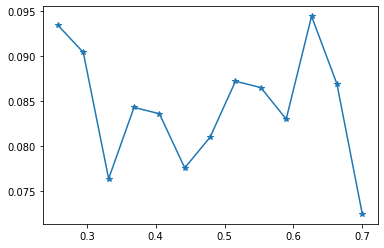

In [64]:
from matplotlib import pyplot as plt

dic = {
    "0.2578947368421053": 0.0934,
    "0.29473684210526313": 0.0904,
    "0.33157894736842103": 0.0764,
    "0.3684210526315789": 0.0843,
    "0.4052631578947368": 0.0836,
    "0.4421052631578947": 0.0776,
    "0.4789473684210526": 0.081,
    "0.5157894736842105": 0.0872,
    "0.5526315789473684": 0.0865,
    "0.5894736842105263": 0.083,
    "0.6263157894736842": 0.0944,
    "0.6631578947368421": 0.0869,
    "0.7": 0.0725
}


x = np.array(list(dic.keys())).astype('float')
y = list(dic.values())

plt.plot(x, y, '-*')
plt.show()